In [1]:
import sys; sys.path.append('/Users/omid/Documents/GitHub/Causality/Quantum_RCC/Scripts')
import numpy as np; np.set_printoptions(precision=3, suppress=True) 
import torch as th; import torch; from torch.utils.data import DataLoader; import torch.nn as nn; import torch.nn.functional as F
import pandas as pd; import networkx as nx
import matplotlib.pyplot as plt; import seaborn as sns; sns.set()
%matplotlib inline
from pathlib import Path; import itertools; import os; import random; import time; import copy
import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
import scipy 
import ast
import modAL
import IPython

import rcc_functions as rcc
import utilities_functions as uFun
import channel_functions as chFun
import distance_functions as dFun
import activeLearning_functions as alFun


In [2]:
split_subsets= ['train', 'valid', 'test']
scenarios    = ['bi_ce', 'bi_ceccin', 'multi_base', 'multi_8node']
scenario     = 'multi_8node'

### Build Featurizer

In [4]:
n_RandComps=50; data_dim=3; scales = list(np.logspace(-1.2, +1.2, 5, True))
#featurizer_obj=rcc.featurizer(n_RandComps=n_RandComps, scales=scales, data_dim=data_dim)
#uFun.object_saver(featurizer_obj, uFun.get_path('featurizer', None, scenario))

featurizer_obj = uFun.object_loader(uFun.get_path('featurizer', None, scenario))

### Apply the Featurizer to the Channel Data

In [5]:
scenario = 'multi_3node'
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = uFun.get_path('ch_container', subset, scenario), 
        featurizer_obj    = featurizer_obj, 
        scenario          = scenario, 
        quad_labeling     = True,
        saving_path       = uFun.get_path('kme_container', subset, scenario))

scenario = 'multi_8node'
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = uFun.get_path('ch_container', subset, scenario), 
        featurizer_obj    = featurizer_obj, 
        scenario          = scenario, 
        quad_labeling     = True,
        saving_path       = uFun.get_path('kme_container', subset, scenario))
    
scenario = 'multi_8node'
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = uFun.get_path('sim_ch_container', subset, scenario), 
        featurizer_obj    = featurizer_obj, 
        scenario          = scenario, 
        quad_labeling     = True,
        saving_path       = uFun.get_path('sim_kme_container', subset, scenario))
IPython.display.clear_output()

### Read KME datasets

In [7]:
scenario = 'multi_3node'
return_unique = False
df_org_s0 = rcc.container_to_df(uFun.get_path('kme_container', 'train', scenario), scenario, return_unique=return_unique)
df_org_s1 = rcc.container_to_df(uFun.get_path('kme_container', 'valid', scenario), scenario, return_unique=return_unique)
df_org_s2 = rcc.container_to_df(uFun.get_path('kme_container', 'test' , scenario), scenario, return_unique=return_unique)
print('df_org_s0={}, df_org_s1={}, df_org_s2={}'.format(df_org_s0.shape, df_org_s1.shape, df_org_s2.shape))

df_org_s0=(3000, 752), df_org_s1=(3000, 752), df_org_s2=(3000, 752)


In [8]:
scenario = 'multi_8node'
return_unique = True
df_org_t0 = rcc.container_to_df(uFun.get_path('kme_container', 'train', scenario), scenario, return_unique=return_unique)
df_org_t1 = rcc.container_to_df(uFun.get_path('kme_container', 'valid', scenario), scenario, return_unique=return_unique)
df_org_t2 = rcc.container_to_df(uFun.get_path('kme_container', 'test' , scenario),  scenario, return_unique=return_unique)
print('df_org_t0={}, df_org_t1={}, df_org_t2={}'.format(df_org_t0.shape, df_org_t1.shape, df_org_t2.shape))

df_sim_t0 = rcc.container_to_df(uFun.get_path('sim_kme_container', 'train', scenario), scenario, return_unique=return_unique)
df_sim_t1 = rcc.container_to_df(uFun.get_path('sim_kme_container', 'valid', scenario), scenario, return_unique=return_unique)
df_sim_t2 = rcc.container_to_df(uFun.get_path('sim_kme_container', 'test' , scenario), scenario, return_unique=return_unique)
print('df_sim_t0={}, df_sim_t1={}, df_sim_t2={}'.format(df_sim_t0.shape, df_sim_t1.shape, df_sim_t2.shape))

df_org_t0=(25536, 752), df_org_t1=(10080, 752), df_org_t2=(15456, 752)
df_sim_t0=(25536, 752), df_sim_t1=(10080, 752), df_sim_t2=(15456, 752)


### Build pool from the sim & org KME datasets 

In [48]:
target_column=1; class_weights=[1,1,1]

df_valid  = uFun.weighted_sampler(df_org_t1, -1)[0]
df_test   = uFun.weighted_sampler(df_org_t2, -1)[0]
X_valid   = df_valid.iloc[:, 2:].values; y_valid = df_valid.iloc[:, target_column].values
X_test    = df_test.iloc [:, 2:].values; y_test  = df_test.iloc [:, target_column].values


df_initial = uFun.weighted_sampler(
    #df_org_s1, 600, 
    df_sim_t1, 600,
    class_weights, 
    target_column)[0]


df_pool = alFun.build_pool(
    class_weights=class_weights, 
    target_column=target_column, 
    source_0 = (df_sim_t0, 4000), 
    source_1 = (df_sim_t1, 2800), 
    source_2 = (df_sim_t2, 4000),    
    #source_3 = (df_org_s0, 2000), 
    source_4 = (df_org_t0, 4000),
)

print('df_valid={}, df_initial={}, df_pool={}'.format(len(df_valid), len(df_initial), len(df_pool)))

[8184, 948, 948]
[12552, 1452, 1452]
[200, 200, 200]
[1333, 1333, 1333]
[933, 933, 933]
[1333, 1333, 1333]
[1333, 1333, 1333]
df_valid=10080, df_initial=600, df_pool=14796


### Define an Active Learner and Apply it to the pool

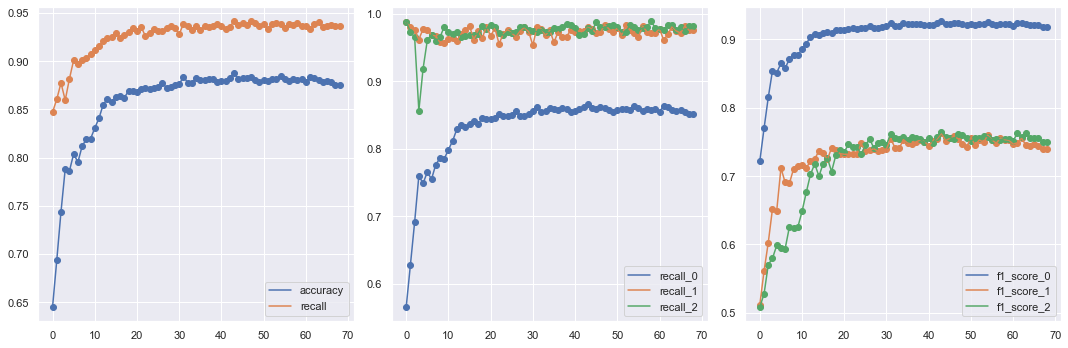

[[0.852 0.075 0.073]
 [0.018 0.976 0.006]
 [0.007 0.011 0.982]]

queries_trend {0: 0.44882352941176473, 1: 0.2732352941176471, 2: 0.27794117647058825}


In [49]:
early_stopper=uFun.EarlyStopping(patience=20, checkpoint_path=uFun.get_path('AL_checkpoint', None, scenario), minimize_score=False, objective='recall')#'recall', 'accuracy' 

estimator = RandomForestClassifier(n_estimators=100, n_jobs=-1)

#estimator = MLPClassifier(hidden_layer_sizes=(100),  activation='tanh', early_stopping=True, max_iter=300)


learner = modAL.models.ActiveLearner(estimator=estimator,
    query_strategy=modAL.uncertainty.margin_sampling); #uncertainty_sampling, margin_sampling, entropy_sampling


AL_result = alFun.fit_AL(
    df_pool=df_pool, df_initial=df_initial, df_valid=df_valid,
    learner = learner, early_stopper=early_stopper,
    instances_perQuery=50, n_queries=100, target_column = target_column, 
    visualizer = uFun.Live_Visualizer('on'),
    saving_path= uFun.get_path('AL_result', None, scenario))

### Check the performance of the base estimator (AL's estimator) 

### 1. On the triple dataset 

### 2. On the whole test dataset

In [42]:
X_train, y_train = AL_result['dataset']
print('Shape of X_train:', X_train.shape)

clf_base = AL_result['estimator']
accuracy, confusion, confusion_n = uFun.clf_report(y_test, clf_base.predict(X_test))
print()
print('clf_base Accuracy:', accuracy)
print()
print(confusion_n)


df_base = uFun.clf_evaluator_meta(
    kme_container = th.load(uFun.get_path('kme_container', 'test', scenario)), 
    clf           = clf_base, 
    n_DAGs        = -1,
    percentile    = 90,
    saving_path   = None)

Shape of X_train: (7799, 750)

clf_base Accuracy: 0.8676242236024845

[[0.84  0.079 0.08 ]
 [0.008 0.988 0.004]
 [0.012 0.004 0.983]]



0. Load the AL Dataset: 
1. Define a more complex clf (NN)  
2. Tune  it!
3. Train it!
4. Save  it! => use it for post-processing! 

### Load the AL Dataset as the training set => df_valid, df_test remain the same 

In [ ]:
X_train, y_train = uFun.object_loader(AL_result_paths[scenario])['dataset']
df_train = pd.DataFrame(np.hstack((y_train.reshape(-1,1), y_train.reshape(-1,1), X_train)))

target_column = 1
return_unique = True
df_valid = rcc.container_to_df(uFun.get_path('kme_container', 'valid', scenario), scenario, return_unique=return_unique)
df_test  = rcc.container_to_df(uFun.get_path('kme_container', 'test', scenario),  scenario, return_unique=return_unique)
X_valid  = df_test.iloc [:, 2:].values; y_valid = df_valid.iloc[:, target_column].values
X_test   = df_test.iloc [:, 2:].values; y_test  = df_test.iloc [:, target_column].values
print('df_train={}, df_valid={}, df_test={}'.format(df_train.shape, df_valid.shape, df_test.shape))

In [44]:
clf = MLPClassifier(
    hidden_layer_sizes=(300, 100),  
    activation='tanh',
    solver='adam', 
    learning_rate_init=1e-4,
    validation_fraction=0.1, 
    #alpha=1e-2, 
    #batch_size = 50,
    n_iter_no_change=30,
    early_stopping=True,
    max_iter=10, verbose=1).fit(X_train, y_train)

IPython.display.clear_output(wait=True)
accuracy, confusion, confusion_n = uFun.clf_report(y_test, clf.predict(X_test))
print()
print('clf_mlp Accuracy:', accuracy)
print(confusion_n)
uFun.object_saver(clf, uFun.get_path('classifier', None, scenario))


clf_mlp Accuracy: 0.8956392339544513
[[0.884 0.061 0.055]
 [0.048 0.947 0.006]
 [0.052 0.003 0.944]]


In [45]:
df_mlp = uFun.clf_evaluator_meta(
    kme_container = th.load(uFun.get_path('kme_container', 'test', scenario)), 
    clf           = uFun.object_loader(uFun.get_path('classifier', None, scenario)), 
    n_DAGs        = -1,
    percentile    = 89,
    saving_path   = None)

Average wrong predictions on 46 DAGs => 
Raw (no post-processing): 2.717
Percentile: 2.174
